# XGB

In [2]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prep3 import DataPreparation
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn import tree

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import classification_report
%matplotlib inline

In [3]:
prep = DataPreparation()

train_db = pd.read_csv("dataset/train_radiomics_hipocamp.csv")
test_db = pd.read_csv("dataset/test_radiomics_hipocamp.csv")
control_db = pd.read_csv("dataset/train_radiomics_occipital_CONTROL.csv")

train_db = prep.prep_train(train_db)
test_db = prep.transform(test_db)
control_db = prep.transform(control_db)

In [4]:
train_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 2162 entries, diagnostics_Image-original_Dimensionality to Transition
dtypes: float64(2161), object(1)
memory usage: 5.0+ MB


In [5]:
test_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 2161 entries, diagnostics_Image-original_Dimensionality to Age
dtypes: float64(2161)
memory usage: 1.6 MB


In [6]:
X = train_db.drop(columns=["Transition"]) 
y = train_db["Transition"]  

In [7]:
X_train = pd.read_csv('prep3/train_X.csv')
X_test = pd.read_csv('prep3/test_X.csv')
y_train = pd.read_csv('prep3/train_y.csv')
y_test = pd.read_csv('prep3/test_y.csv')

Rótulos após codificação: ['AD-AD' 'CN-CN' 'CN-MCI' 'MCI-AD' 'MCI-MCI']
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Melhores parâmetros encontrados: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8}
F1 Score médio com validação cruzada: 0.3567223742202071


/home/tiagogr/miniconda3/envs/DAA/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/tiagogr/miniconda3/envs/DAA/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Matriz de Confusão:


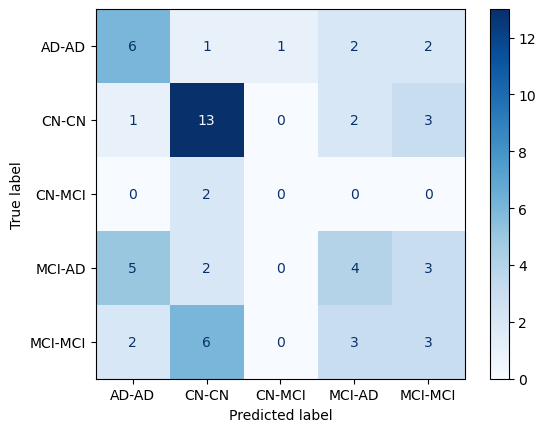


Relatório de Classificação:
              precision    recall  f1-score   support

       AD-AD       0.43      0.50      0.46        12
       CN-CN       0.54      0.68      0.60        19
      CN-MCI       0.00      0.00      0.00         2
      MCI-AD       0.36      0.29      0.32        14
     MCI-MCI       0.27      0.21      0.24        14

    accuracy                           0.43        61
   macro avg       0.32      0.34      0.33        61
weighted avg       0.40      0.43      0.41        61



In [13]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 
print("Rótulos após codificação:", label_encoder.classes_)

clf = XGBClassifier(
    random_state=2024, 
    eval_metric='logloss'
)

param_grid = {
    'n_estimators': [50],
    'max_depth': [3],               
    'learning_rate': [0.3],    
    'subsample': [0.8],              
    'colsample_bytree': [0.6],       
    'min_child_weight': [1],        
    'gamma': [0.1]                
}


cv_strategy = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='f1_macro',  
    cv=cv_strategy,        
    verbose=1,              
    refit=True,
    n_jobs=-1
)

grid_search.fit(X, y_encoded)

print("Melhores parâmetros encontrados:", grid_search.best_params_)

best_model = grid_search.best_estimator_

print("F1 Score médio com validação cruzada:", grid_search.best_score_)

y_train_encoded = label_encoder.transform(y_train)  
best_model.fit(X_train, y_train_encoded)

y_test_encoded = label_encoder.transform(y_test)  
y_pred_encoded = best_model.predict(X_test)

# Decodificar as previsões para rótulos originais
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Matriz de confusão
print("Matriz de Confusão:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


### Testar Controlo

F1-Score no conjunto de controle: 0.190171323669045


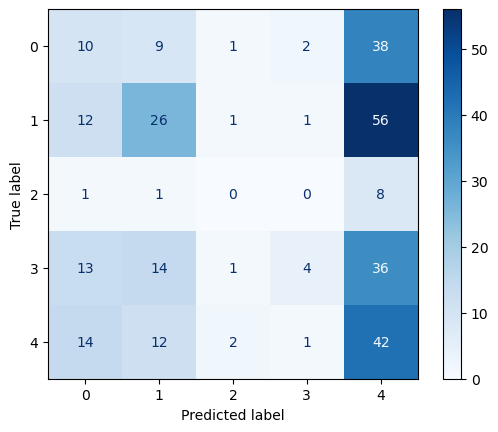

In [14]:
CX = control_db.drop(columns=["Transition"]) 
Cy = control_db["Transition"]  

Cy_encoded = label_encoder.transform(Cy)

control_pred = best_model.predict(CX)

control_f1_score = f1_score(Cy_encoded, control_pred, average='macro')
print("F1-Score no conjunto de controle:", control_f1_score)

# Matriz de Confusão
ConfusionMatrixDisplay.from_predictions(Cy_encoded, control_pred, cmap='Blues')
plt.show()


### Guardar o melhor modelo do XGB

In [9]:
y_encoded_full = label_encoder.fit_transform(y)

best_model.fit(X, y_encoded_full)

test_predictions_encoded = best_model.predict(test_db)

test_predictions = label_encoder.inverse_transform(test_predictions_encoded)

row_ids = range(1, len(test_predictions) + 1)
output_df = pd.DataFrame({
    "RowId": row_ids,
    "Result": test_predictions
})

output_df.to_csv("resultados/xgb3.csv", index=False)